In [6]:
using Pkg; Pkg.activate(".")
using Revise
import MUST
using PyPlot 
using DelimitedFiles

MUST.@import_dispatch "/u/peitner/DISPATCH/dispatch2";

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/solar_model/Project.toml`


In [7]:
eos_path = "input_data/TSO_sun_Magg_v2"
#eos_path = "/u/peitner/Turbospectrum/opacity_tables/tests/TSO_sun_Magg_dummy"
TSO      = MUST.SquareGasEOS(MUST.@in_dispatch(eos_path));

eos_path = "input_data/solar_lte"
TAB      = MUST.SquareGasEOS(MUST.@in_dispatch(eos_path));

In [8]:
folder_stagger = "/ptmp/peitner/model_grid/MUST.jl/examples/stagger2bifrost"
stagger        = MUST.Box("box_solar_stagger", folder=folder_stagger);

MUST.box_dimensions(6000, exp10(stagger_ini2.logg)) = Dict(:z => 3.6397847311729854, :x => 1.3519200430071088)


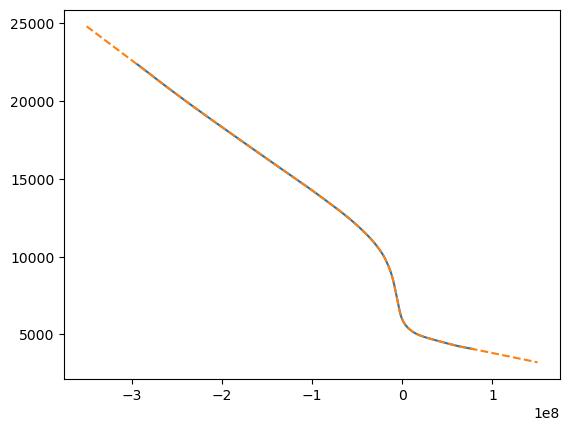

In [9]:
# An average 3D initial model
close()
stagger_ini  = MUST.cut(MUST.SimpleInitialModel(stagger, Teff=5777.0, logg=4.5), z=(-3e8, 0.8e8))
stagger_ini2 = MUST.regrid(stagger_ini, collect(range(-3.5e8, 1.5e8, length=200)))
#MUST.for_dispatch(stagger_ini2, "solar_stagger_ext")

@show MUST.box_dimensions(6000, exp10(stagger_ini2.logg))

plt.plot(stagger_ini.z, stagger_ini.T)
plt.plot(stagger_ini2.z, stagger_ini2.T, ls="--")
gcf()

In [10]:
#z0   = -2.5
#imin = argmin(abs.(stagger_ini2.z .- z0*1e8))
#g    = 2.75e4
#T    = Float64(stagger_ini2.T[imin])
#lnR  = Float64(exp(stagger_ini2.lnρ[imin]));

#@show T lnR

#z_tso,d_tso,ee_tso,t_tso,p_tso = MUST.initial_adiabat(TSO, T, lnR, g, nz=400, i0=10, z0_position=z0)

In [66]:
t_ini = 11400
r_ini = 3.3e-7
g_ini = 2.75e4
z0    = -0.1

z_tso,d_tso,ee_tso,t_tso,p_tso = MUST.initial_adiabat(TSO, t_ini, r_ini, g_ini, nz=300, i0=150, z0_position=z0)
z_tab,d_tab,ee_tab,t_tab,p_tab = MUST.initial_adiabat(TAB, t_ini, r_ini, g_ini, nz=400, i0=150, z0_position=z0);

In [67]:
z_tab

400-element Vector{Float64}:
 -8.914357290161082
 -8.717060377385438
 -8.525939897127087
 -8.340779004379005
 -8.161353481559745
 -7.987447968708702
 -7.8188285695653
 -7.655288335607885
 -7.496607064741615
 -7.342585050759924
  ⋮
  1.7767540909251383
  1.7819632220359423
  1.7871716575001588
  1.7923796345434075
  1.797587105429385
  1.8027939955601437
  1.808000404374594
  1.8132061967324946
  1.818411344195955

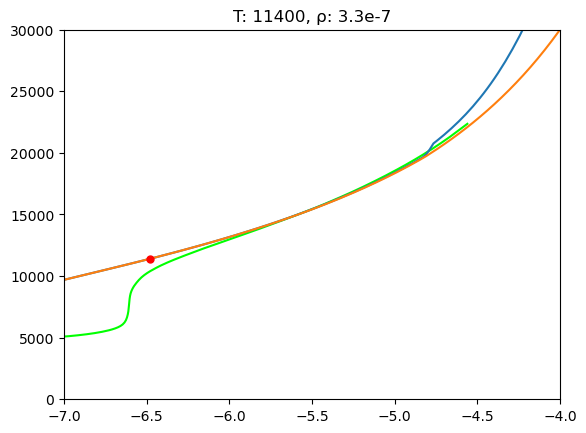

In [68]:
t_stagger = MUST.plane_statistic(MUST.mean, stagger, :T)
d_stagger = MUST.plane_statistic(MUST.mean, stagger, :d)
z_stagger = MUST.axis(stagger, :z)

d_stagger = log10.(d_stagger)

# Plotting
close()
plt.title("T: $(t_ini), ρ: $(r_ini)", fontsize="large")

#plt.scatter(log10.(stagger[:d]), stagger[:T], s=0.05, color="k")
plt.plot(d_stagger, t_stagger, color="lime")

plt.plot(log10.(d_tso), t_tso, label="TS-EoS")
plt.plot(log10.(d_tab), t_tab, label="Tabgen-EoS")

plt.plot(log10(r_ini), t_ini, marker="o", markersize=5, color="red")

plt.ylim(0,30000)
plt.xlim(-7,-4)

gcf()

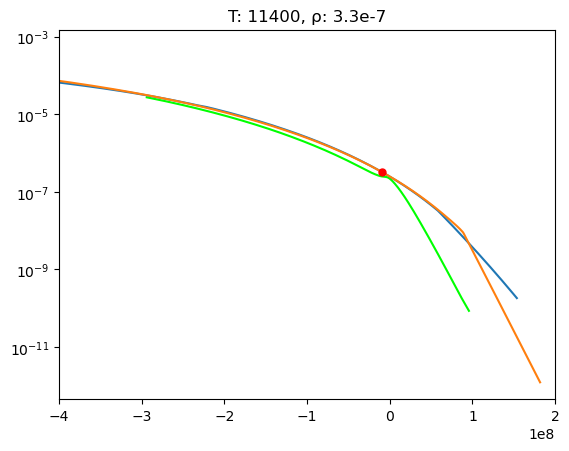

In [69]:
close()
d_stagger = MUST.plane_statistic(MUST.mean, stagger, :d)
z_stagger = MUST.axis(stagger, :z)

# Plotting
plt.title("T: $(t_ini), ρ: $(r_ini)", fontsize="large")

#plt.scatter(stagger[:z], stagger[:T], s=0.05, color="k")
plt.plot(z_stagger, d_stagger, color="lime")

plt.plot(z_tso.*1e8, d_tso, label="TS-EoS")
plt.plot(z_tab.*1e8, d_tab, label="TS-EoS")

plt.plot(z0.*1e8, r_ini, marker="o", markersize=5, color="red")

plt.xlim(-4e8, 2e8)
plt.yscale("log")
#plt.legend();

gcf()

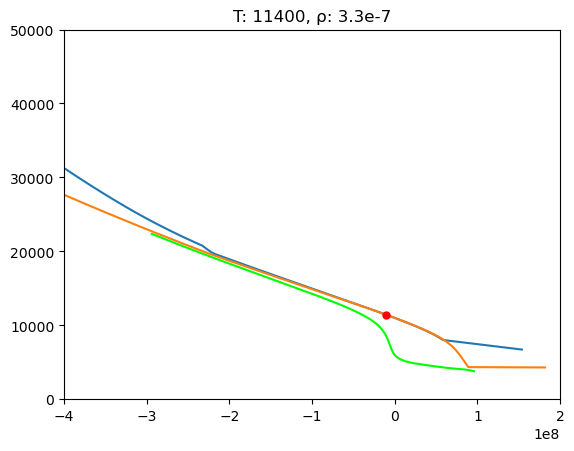

In [70]:
t_stagger = MUST.plane_statistic(MUST.mean, stagger, :T)
z_stagger = MUST.axis(stagger, :z)

close()
# Plotting
plt.title("T: $(t_ini), ρ: $(r_ini)", fontsize="large")

#plt.scatter(stagger[:z], stagger[:T], s=0.05, color="k")
plt.plot(z_stagger, t_stagger, color="lime")

plt.plot(z_tso.*1e8, t_tso, label="TS-EoS")
plt.plot(z_tab.*1e8, t_tab, label="TS-EoS")

plt.plot(z0.*1e8, t_ini, marker="o", markersize=5, color="red")

plt.ylim(0,50000);
plt.xlim(-4e8, 2e8)

#plt.legend();

gcf()

plot multiple initial conditions

In [16]:
t_ini = 1e4
r_ini = 3e-7
g_ini = 2.75e4;
z0    = 0.0


t_stagger = MUST.plane_statistic(MUST.mean, stagger, :T)
d_stagger = MUST.plane_statistic(MUST.mean, stagger, :d)
z_stagger = MUST.axis(stagger, :z)

z_tab,d_tab,ee_tab,t_tab,p_tab = init_adiabat(TAB, t_ini, r_ini, g_ini, ee_min=4.0, nz=400, i0=150, placement=z0);

z = []
d = []
t = []
e = []
p = []


z_tso,d_tso,ee_tso,t_tso,p_tso = init_adiabat(TSO, t_ini+700, r_ini, g_ini, ee_min=3.3, nz=400, i0=150, placement=z0)
append!(z, [z_tso]);append!(d, [d_tso]);append!(e, [ee_tso]);append!(t, [t_tso]);append!(p, [p_tso])

z_tso,d_tso,ee_tso,t_tso,p_tso = init_adiabat(TSO, t_ini+500, r_ini, g_ini, ee_min=3.3, nz=400, i0=150, placement=z0)
append!(z, [z_tso]);append!(d, [d_tso]);append!(e, [ee_tso]);append!(t, [t_tso]);append!(p, [p_tso])

z_tso,d_tso,ee_tso,t_tso,p_tso = init_adiabat(TSO, t_ini+200, r_ini, g_ini, ee_min=3.3, nz=400, i0=150, placement=z0)
append!(z, [z_tso]);append!(d, [d_tso]);append!(e, [ee_tso]);append!(t, [t_tso]);append!(p, [p_tso])

z_tso,d_tso,ee_tso,t_tso,p_tso = init_adiabat(TSO, t_ini,     r_ini, g_ini, ee_min=3.3, nz=400, i0=150, placement=z0)
append!(z, [z_tso]);append!(d, [d_tso]);append!(e, [ee_tso]);append!(t, [t_tso]);append!(p, [p_tso])

z_tso,d_tso,ee_tso,t_tso,p_tso = init_adiabat(TSO, t_ini-200, r_ini, g_ini, ee_min=3.3, nz=400, i0=150, placement=z0)
append!(z, [z_tso]);append!(d, [d_tso]);append!(e, [ee_tso]);append!(t, [t_tso]);append!(p, [p_tso])

z_tso,d_tso,ee_tso,t_tso,p_tso = init_adiabat(TSO, t_ini-500, r_ini, g_ini, ee_min=3.3, nz=400, i0=150, placement=z0)
append!(z, [z_tso]);append!(d, [d_tso]);append!(e, [ee_tso]);append!(t, [t_tso]);append!(p, [p_tso])

z_tso,d_tso,ee_tso,t_tso,p_tso = init_adiabat(TSO, t_ini-700, r_ini, g_ini, ee_min=3.3, nz=400, i0=150, placement=z0)
append!(z, [z_tso]);append!(d, [d_tso]);append!(e, [ee_tso]);append!(t, [t_tso]);append!(p, [p_tso])
;

UndefVarError: UndefVarError: init_adiabat not defined

In [17]:
cmap  = plt.get_cmap("seismic")    # 11 discrete colors

for i in eachindex(z)
    plt.plot(z[i], t[i], color=cmap(i/length(z)))
end

plt.plot(z_stagger ./1e8, t_stagger, color="lime")
plt.plot(z_tab, t_tab, color="orange", lw=3)

plt.xlim(-2,1)
plt.ylim(0,20000)
#plt.yscale("log")

UndefVarError: UndefVarError: z not defined

In [18]:
cmap  = plt.get_cmap("Blues")    # 11 discrete colors

plt.plot(d_stagger, t_stagger, color="lime")
plt.plot(d_tab, t_tab, color="orange", lw=3, label="Tabgen-EoS")

for i in eachindex(z)
    i != 4 && continue
    plt.plot(d[i], t[i], color=cmap(i/length(z)), lw=3, label="TS-EoS")
end

plt.xscale("log")
plt.xlim(1e-5, 1e-3)
plt.ylim(15000,70000)
plt.axhline(20000, color="k", ls=":", lw=0.5, label="TMOLIM")

plt.xlabel("Density")
plt.ylabel("Temperature")

plt.legend()
#plt.yscale("log")

UndefVarError: UndefVarError: z not defined

Compare the EoS themselves

In [19]:
@show minimum(TAB.lnRho_axis) maximum(TAB.lnRho_axis) 

minimum(TAB.lnRho_axis) = -36.841362f0
maximum(TAB.lnRho_axis) = -6.9077554f0


-6.9077554f0

In [20]:
@show minimum(TSO.lnRho_axis) maximum(TSO.lnRho_axis) 

minimum(TSO.lnRho_axis) = -34.538776f0
maximum(TSO.lnRho_axis) = -6.9077554f0


-6.9077554f0

In [21]:
#@show TAB.lnRho_axis[1650]
@show TAB.lnRho_axis[1650]
@show TSO.lnRho_axis[150]

TAB.lnRho_axis[1650] = -12.727773f0
TSO.lnRho_axis[150] = -12.870239f0


-12.870239f0

In [22]:
tab_ee_range = [Float32(TAB.params["EiMin"]), Float32(TAB.params["EiMax"])] 
tso_ee_range = [Float32(TSO.params["EiMin"]), Float32(TSO.params["EiMax"])] 
@show tab_e = MUST.bisect(TAB; ee=tab_ee_range, d=3e-7, T=10000)
@show tso_e = MUST.bisect(TSO; ee=tso_ee_range, d=3e-7, T=10000)
diff_e = tso_e - tab_e

tab_e = MUST.bisect(TAB; ee = tab_ee_range, d = 3.0e-7, T = 10000) = 5.112688f12
tso_e = MUST.bisect(TSO; ee = tso_ee_range, d = 3.0e-7, T = 10000) = 

4.546265f12


-5.664229f11

In [23]:
plt.plot(TAB.eostable[:, 1650, 1], TAB.eostable[:, 1650, 2], label="tabgen")
#plt.plot(log.(exp.(TSO.lnEi_axis) .- diff_e), TSO.eostable[:, 150, 2], label="ts")
plt.plot(TSO.eostable[:, 150, 1], TSO.eostable[:, 150, 2], label="ts")

plt.yscale("log")

In [24]:
plt.plot(TAB.lnEi_axis, TAB.eostable[:, 1650, 2], label="tabgen")
plt.plot(log.(exp.(TSO.lnEi_axis) .- diff_e), TSO.eostable[:, 150, 2], label="ts")
#plt.plot(TSO.lnEi_axis, TSO.eostable[:, 150, 2], label="ts")


plt.yscale("log")

#plt.axhline(300000)
plt.axhline(200000, ls="--")
plt.axhline(20000, ls="--")
plt.axhline(50000, ls="--")


#plt.ylim(1e4, 1e5)
#plt.xlim(29,31.5)

plt.legend()

PyObject <matplotlib.legend.Legend object at 0x2ae789c50130>

In [25]:
plt.plot(TAB.lnEi_axis, TAB.eostable[:, 1650, 1], label="tabgen")
#plt.plot(log.(exp.(TSO.lnEi_axis) .- diff_e), TSO.eostable[:, 150, 1], label="ts")
plt.plot(TSO.lnEi_axis, TSO.eostable[:, 150, 1], label="ts")

plt.legend()

PyObject <matplotlib.legend.Legend object at 0x2ae789cdbf40>

In [26]:
plt.plot(TAB.lnEi_axis, TAB.eostable[:, 1650, 3], label="tabgen")
plt.plot(log.(exp.(TSO.lnEi_axis) .- diff_e), TSO.eostable[:, 150, 3], label="ts")
#plt.plot(TSO.lnEi_axis, TSO.eostable[:, 150, 3], label="ts")


plt.legend()
plt.ylim(35,42)

(35, 42)

In [27]:
plt.plot(TAB.lnEi_axis, TAB.eostable[:, 1650, 4], label="tabgen")
plt.plot(log.(exp.(TSO.lnEi_axis) .- diff_e), TSO.eostable[:, 150, 4], label="ts")
#plt.plot(TSO.lnEi_axis, TSO.eostable[:, 150, 4], label="ts")


plt.legend()

PyObject <matplotlib.legend.Legend object at 0x2ae789cfc250>